# COVID-19 face mask detector with CNN, OpenCV

In [ ]:
!pip install imutils

In [ ]:
!pip install pytesseract

In [ ]:
!pip3 install bayesian-optimization

In [ ]:
!pip install pygame

In [1]:
import cv2,os
import numpy as np
from tensorflow.python.keras.utils import np_utils
import imutils
import pytesseract
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
%matplotlib inline

# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [2]:
np.__version__

'1.24.3'

In [3]:
cv2.__version__

'4.8.0'

In [4]:
tf.__version__

'2.13.0'

In [5]:
keras.__version__

'2.13.1'

#### 데이터 라벨 만들기

In [6]:
data_path='../data/mask_data/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

In [7]:
label_dict

{'without_mask': 0, 'with_mask': 1}

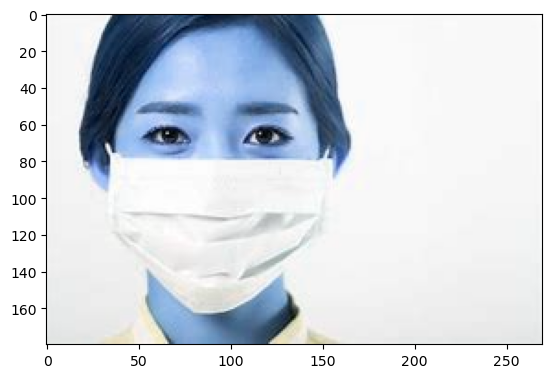

In [8]:
img = cv2.imread('../data/mask_data/with_mask/601-with-mask.jpg')
plt.imshow(img)

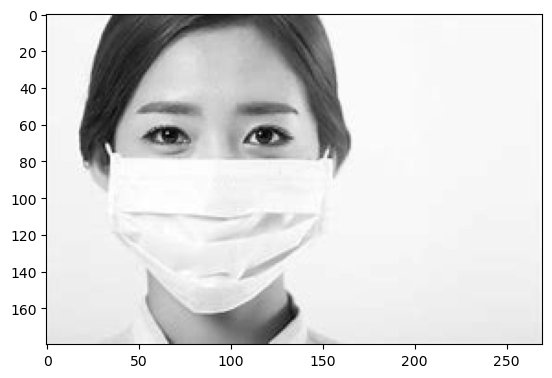

In [9]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap = 'gray')

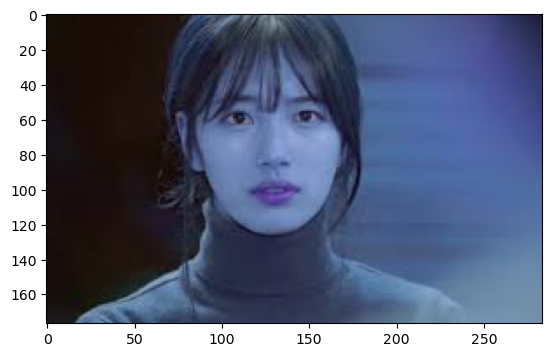

In [10]:
img = cv2.imread('../data/mask_data/without_mask/551.jpg')
plt.imshow(img)

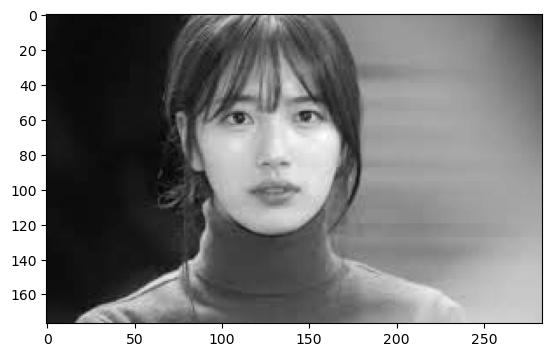

In [11]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap = 'gray')

### #데이터 불러오기

In [12]:
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
            resized=cv2.resize(gray,(100, 100))
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:', e)

In [13]:
categories

['without_mask', 'with_mask']

In [14]:
folder_path

'../data/mask_data/with_mask'

In [15]:
img_names[:5]

['0-with-mask.jpg',
 '101-with-mask.jpg',
 '106-with-mask.jpg',
 '108-with-mask.jpg',
 '109-with-mask.jpg']

In [16]:
data[:3]

[array([[218, 215, 212, ..., 168, 155, 152],
        [215, 212, 204, ..., 189, 183, 159],
        [201, 198, 190, ..., 162, 167, 158],
        ...,
        [ 33,  53,  70, ...,  14,  14,  15],
        [ 31,  54,  77, ...,  19,  19,  17],
        [ 33,  56,  77, ...,  25,  27,  23]], dtype=uint8),
 array([[180, 173, 175, ..., 186, 163, 137],
        [178, 174, 175, ..., 174, 151, 135],
        [174, 178, 177, ..., 153, 134, 145],
        ...,
        [203, 201, 196, ..., 153, 152, 161],
        [201, 200, 195, ..., 159, 156, 159],
        [194, 196, 199, ..., 155, 166, 143]], dtype=uint8),
 array([[255, 255, 255, ..., 254, 254, 254],
        [255, 255, 255, ..., 254, 254, 254],
        [254, 254, 250, ..., 228, 218, 209],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)]

In [17]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0], 100, 100, 1))
target=np.array(target)

new_target=np_utils.to_categorical(target)

np.save('data', data)
np.save('target', new_target)

In [18]:
new_target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [19]:
data=np.load('data.npy')
target=np.load('target.npy')

In [20]:
data.shape

(615, 100, 100, 1)

In [21]:
target.shape

(615, 2)

In [22]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v2 import rmsprop

### #학습용 데이터와 검증용 데이터 세트로 분할하기

In [23]:
train_data,test_data,train_target,test_target=train_test_split(data,target, test_size=0.2, random_state=42)

In [24]:
train_data.shape

(492, 100, 100, 1)

### *Data augmentation to improve generalization

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.2, 
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15, 
                         horizontal_flip=True,
                         fill_mode="nearest")

### *Hyperparameter Tuning With Bayesian Optimization

In [26]:
input_shape=data.shape[1:]
input_shape

(100, 100, 1)

In [27]:
def get_model(input_shape, dropout2_rate=0.5):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     name="conv2d_1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name="conv2d_2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_1"))
    model.add(Dropout(0.25, name="dropout_1"))
    model.add(Flatten(name="flatten"))
    model.add(Dense(128, activation='relu', name="dense_1"))
    model.add(Dropout(dropout2_rate, name="dropout_2"))
    model.add(Dense(2, activation='softmax', name="dense_2"))
    return model

In [28]:
from tensorflow.keras.optimizers import RMSprop

def fit_with(input_shape, verbose, dropout2_rate, lr):

    model = get_model(input_shape, dropout2_rate)
    optimizer = 'rmsprop'
    #optimizer = rmsprop.RMSProp(learning_rate=lr)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    model.fit(train_data, train_target, epochs=10,
              batch_size=4, verbose=verbose)

    score = model.evaluate(test_data, test_target, steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return score[1]

In [ ]:
# from functools import partial

# # verbose = 1
# fit_with_partial = partial(fit_with, input_shape = (100, 100, 1), verbose = 1)

In [ ]:
# from bayes_opt import BayesianOptimization

# pbounds = {'dropout2_rate': (0.1, 0.5), 'lr': (1e-4, 1e-2)}

# optimizer = BayesianOptimization(
#     f=fit_with_partial,
#     pbounds=pbounds,
#     verbose=2, 
#     random_state=1
# )

# optimizer.maximize(init_points=10, n_iter=10)

# for i, res in enumerate(optimizer.res):
#     print("Iteration {}: \n\t{}".format(i, res))

In [ ]:
# print(optimizer.max)

### * Build the CNN model

In [30]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),input_shape=data.shape[1:], activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1942))
model.add(Dense(2, activation='softmax'))

In [31]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
checkpoint = ModelCheckpoint(
    '{epoch:03d}-{val_loss:.4f}.model',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto')

### *Train the model

In [35]:
history=model.fit(aug.flow(train_data, train_target), 
                  epochs=100, 
                  batch_size=4,
                  callbacks=[checkpoint, early_stopping],
                  validation_data=(test_data, test_target))

print(model.evaluate(test_data,test_target))

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.5226 - accuracy: 0.7561INFO:tensorflow:Assets written to: 001-0.4645.model\assets


INFO:tensorflow:Assets written to: 001-0.4645.model\assets


16/16 [==============================] - 7s 450ms/step - loss: 0.5226 - accuracy: 0.7561 - val_loss: 0.4645 - val_accuracy: 0.7967
Epoch 2/100
16/16 [==============================] - 6s 402ms/step - loss: 0.5513 - accuracy: 0.7256 - val_loss: 0.5320 - val_accuracy: 0.7073
Epoch 3/100
16/16 [==============================] - 6s 387ms/step - loss: 0.5827 - accuracy: 0.7215 - val_loss: 0.4872 - val_accuracy: 0.8130
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.5332 - accuracy: 0.7480INFO:tensorflow:Assets written to: 004-0.4578.model\assets


INFO:tensorflow:Assets written to: 004-0.4578.model\assets


16/16 [==============================] - 7s 446ms/step - loss: 0.5332 - accuracy: 0.7480 - val_loss: 0.4578 - val_accuracy: 0.8130
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.7724INFO:tensorflow:Assets written to: 005-0.4437.model\assets


INFO:tensorflow:Assets written to: 005-0.4437.model\assets


16/16 [==============================] - 7s 453ms/step - loss: 0.5057 - accuracy: 0.7724 - val_loss: 0.4437 - val_accuracy: 0.8049
Epoch 6/100
16/16 [==============================] - ETA: 0s - loss: 0.4821 - accuracy: 0.7805INFO:tensorflow:Assets written to: 006-0.4341.model\assets


INFO:tensorflow:Assets written to: 006-0.4341.model\assets


16/16 [==============================] - 7s 458ms/step - loss: 0.4821 - accuracy: 0.7805 - val_loss: 0.4341 - val_accuracy: 0.7967
Epoch 7/100
16/16 [==============================] - 7s 407ms/step - loss: 0.5069 - accuracy: 0.7683 - val_loss: 0.4401 - val_accuracy: 0.8211
Epoch 8/100
16/16 [==============================] - 6s 403ms/step - loss: 0.4707 - accuracy: 0.7947 - val_loss: 0.4433 - val_accuracy: 0.8374
Epoch 9/100
16/16 [==============================] - 6s 393ms/step - loss: 0.4959 - accuracy: 0.7663 - val_loss: 0.4606 - val_accuracy: 0.8049
Epoch 10/100
16/16 [==============================] - 6s 402ms/step - loss: 0.4952 - accuracy: 0.7500 - val_loss: 0.4355 - val_accuracy: 0.8211
Epoch 11/100
16/16 [==============================] - ETA: 0s - loss: 0.4548 - accuracy: 0.7825INFO:tensorflow:Assets written to: 011-0.4202.model\assets


INFO:tensorflow:Assets written to: 011-0.4202.model\assets


16/16 [==============================] - 7s 452ms/step - loss: 0.4548 - accuracy: 0.7825 - val_loss: 0.4202 - val_accuracy: 0.8455
Epoch 12/100
16/16 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.8049INFO:tensorflow:Assets written to: 012-0.4088.model\assets


INFO:tensorflow:Assets written to: 012-0.4088.model\assets


16/16 [==============================] - 7s 445ms/step - loss: 0.4553 - accuracy: 0.8049 - val_loss: 0.4088 - val_accuracy: 0.8211
Epoch 13/100
16/16 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.7927INFO:tensorflow:Assets written to: 013-0.4067.model\assets


INFO:tensorflow:Assets written to: 013-0.4067.model\assets


16/16 [==============================] - 7s 437ms/step - loss: 0.4600 - accuracy: 0.7927 - val_loss: 0.4067 - val_accuracy: 0.7967
Epoch 14/100
16/16 [==============================] - 6s 388ms/step - loss: 0.4992 - accuracy: 0.7459 - val_loss: 0.4293 - val_accuracy: 0.7805
Epoch 15/100
16/16 [==============================] - 6s 385ms/step - loss: 0.4409 - accuracy: 0.8028 - val_loss: 0.4275 - val_accuracy: 0.7805
Epoch 16/100
16/16 [==============================] - ETA: 0s - loss: 0.4536 - accuracy: 0.7967INFO:tensorflow:Assets written to: 016-0.4046.model\assets


INFO:tensorflow:Assets written to: 016-0.4046.model\assets


16/16 [==============================] - 7s 441ms/step - loss: 0.4536 - accuracy: 0.7967 - val_loss: 0.4046 - val_accuracy: 0.8211
Epoch 17/100
16/16 [==============================] - 6s 392ms/step - loss: 0.4525 - accuracy: 0.7947 - val_loss: 0.4134 - val_accuracy: 0.7805
Epoch 18/100
16/16 [==============================] - ETA: 0s - loss: 0.4536 - accuracy: 0.7846INFO:tensorflow:Assets written to: 018-0.3922.model\assets


INFO:tensorflow:Assets written to: 018-0.3922.model\assets


16/16 [==============================] - 7s 439ms/step - loss: 0.4536 - accuracy: 0.7846 - val_loss: 0.3922 - val_accuracy: 0.8293
Epoch 19/100
16/16 [==============================] - 6s 391ms/step - loss: 0.4408 - accuracy: 0.8049 - val_loss: 0.4164 - val_accuracy: 0.8293
Epoch 20/100
16/16 [==============================] - 6s 391ms/step - loss: 0.4693 - accuracy: 0.7744 - val_loss: 0.4107 - val_accuracy: 0.8211
Epoch 21/100
16/16 [==============================] - ETA: 0s - loss: 0.4061 - accuracy: 0.8232INFO:tensorflow:Assets written to: 021-0.3851.model\assets


INFO:tensorflow:Assets written to: 021-0.3851.model\assets


16/16 [==============================] - 7s 451ms/step - loss: 0.4061 - accuracy: 0.8232 - val_loss: 0.3851 - val_accuracy: 0.8293
Epoch 22/100
16/16 [==============================] - 6s 392ms/step - loss: 0.4384 - accuracy: 0.8028 - val_loss: 0.4150 - val_accuracy: 0.8211
Epoch 23/100
16/16 [==============================] - ETA: 0s - loss: 0.4440 - accuracy: 0.7846INFO:tensorflow:Assets written to: 023-0.3807.model\assets


INFO:tensorflow:Assets written to: 023-0.3807.model\assets


16/16 [==============================] - 7s 446ms/step - loss: 0.4440 - accuracy: 0.7846 - val_loss: 0.3807 - val_accuracy: 0.8455
Epoch 24/100
16/16 [==============================] - ETA: 0s - loss: 0.4141 - accuracy: 0.8049INFO:tensorflow:Assets written to: 024-0.3805.model\assets


INFO:tensorflow:Assets written to: 024-0.3805.model\assets


16/16 [==============================] - 7s 454ms/step - loss: 0.4141 - accuracy: 0.8049 - val_loss: 0.3805 - val_accuracy: 0.8374
Epoch 25/100
16/16 [==============================] - 8s 527ms/step - loss: 0.4031 - accuracy: 0.8232 - val_loss: 0.4053 - val_accuracy: 0.8211
Epoch 26/100
16/16 [==============================] - 10s 599ms/step - loss: 0.4241 - accuracy: 0.8150 - val_loss: 0.3805 - val_accuracy: 0.8211
Epoch 27/100
16/16 [==============================] - ETA: 0s - loss: 0.3890 - accuracy: 0.8394INFO:tensorflow:Assets written to: 027-0.3725.model\assets


INFO:tensorflow:Assets written to: 027-0.3725.model\assets


16/16 [==============================] - 10s 667ms/step - loss: 0.3890 - accuracy: 0.8394 - val_loss: 0.3725 - val_accuracy: 0.8293
Epoch 28/100
16/16 [==============================] - 9s 566ms/step - loss: 0.4202 - accuracy: 0.8049 - val_loss: 0.3759 - val_accuracy: 0.8211
Epoch 29/100
16/16 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.8130INFO:tensorflow:Assets written to: 029-0.3653.model\assets


INFO:tensorflow:Assets written to: 029-0.3653.model\assets


16/16 [==============================] - 10s 613ms/step - loss: 0.4240 - accuracy: 0.8130 - val_loss: 0.3653 - val_accuracy: 0.8537
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.7724INFO:tensorflow:Assets written to: 030-0.3627.model\assets


INFO:tensorflow:Assets written to: 030-0.3627.model\assets


16/16 [==============================] - 10s 618ms/step - loss: 0.4619 - accuracy: 0.7724 - val_loss: 0.3627 - val_accuracy: 0.8374
Epoch 31/100
16/16 [==============================] - 8s 493ms/step - loss: 0.4328 - accuracy: 0.7907 - val_loss: 0.3650 - val_accuracy: 0.8537
Epoch 32/100
16/16 [==============================] - 8s 495ms/step - loss: 0.4221 - accuracy: 0.8130 - val_loss: 0.3814 - val_accuracy: 0.8374
Epoch 33/100
16/16 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.8374INFO:tensorflow:Assets written to: 033-0.3611.model\assets


INFO:tensorflow:Assets written to: 033-0.3611.model\assets


16/16 [==============================] - 9s 549ms/step - loss: 0.3874 - accuracy: 0.8374 - val_loss: 0.3611 - val_accuracy: 0.8455
Epoch 34/100
16/16 [==============================] - 7s 462ms/step - loss: 0.3910 - accuracy: 0.8394 - val_loss: 0.3648 - val_accuracy: 0.8293
Epoch 35/100
16/16 [==============================] - 7s 454ms/step - loss: 0.4065 - accuracy: 0.8089 - val_loss: 0.3909 - val_accuracy: 0.8130
Epoch 36/100
16/16 [==============================] - 7s 452ms/step - loss: 0.4144 - accuracy: 0.8211 - val_loss: 0.3693 - val_accuracy: 0.8211
Epoch 37/100
16/16 [==============================] - 7s 454ms/step - loss: 0.3896 - accuracy: 0.8293 - val_loss: 0.4345 - val_accuracy: 0.7642
Epoch 38/100
16/16 [==============================] - ETA: 0s - loss: 0.4040 - accuracy: 0.8252INFO:tensorflow:Assets written to: 038-0.3486.model\assets


INFO:tensorflow:Assets written to: 038-0.3486.model\assets


16/16 [==============================] - 8s 519ms/step - loss: 0.4040 - accuracy: 0.8252 - val_loss: 0.3486 - val_accuracy: 0.8618
Epoch 39/100
16/16 [==============================] - 7s 448ms/step - loss: 0.3889 - accuracy: 0.8171 - val_loss: 0.3522 - val_accuracy: 0.8537
Epoch 40/100
16/16 [==============================] - 7s 467ms/step - loss: 0.3704 - accuracy: 0.8374 - val_loss: 0.3514 - val_accuracy: 0.8618
Epoch 41/100
16/16 [==============================] - 8s 474ms/step - loss: 0.3769 - accuracy: 0.8435 - val_loss: 0.3516 - val_accuracy: 0.8293
Epoch 42/100
16/16 [==============================] - 7s 452ms/step - loss: 0.4135 - accuracy: 0.8191 - val_loss: 0.3496 - val_accuracy: 0.8618
Epoch 43/100
16/16 [==============================] - 6s 399ms/step - loss: 0.3749 - accuracy: 0.8333 - val_loss: 0.3570 - val_accuracy: 0.8211
Epoch 44/100
16/16 [==============================] - 6s 395ms/step - loss: 0.3541 - accuracy: 0.8516 - val_loss: 0.3992 - val_accuracy: 0.8211
Epoch

INFO:tensorflow:Assets written to: 049-0.3468.model\assets


16/16 [==============================] - 7s 449ms/step - loss: 0.3632 - accuracy: 0.8354 - val_loss: 0.3468 - val_accuracy: 0.8374
Epoch 50/100
16/16 [==============================] - 6s 396ms/step - loss: 0.3690 - accuracy: 0.8476 - val_loss: 0.3490 - val_accuracy: 0.8455
Epoch 51/100
16/16 [==============================] - 6s 395ms/step - loss: 0.3602 - accuracy: 0.8374 - val_loss: 0.3640 - val_accuracy: 0.8455
Epoch 52/100
16/16 [==============================] - ETA: 0s - loss: 0.3623 - accuracy: 0.8455INFO:tensorflow:Assets written to: 052-0.3450.model\assets


INFO:tensorflow:Assets written to: 052-0.3450.model\assets


16/16 [==============================] - 7s 447ms/step - loss: 0.3623 - accuracy: 0.8455 - val_loss: 0.3450 - val_accuracy: 0.8537
Epoch 53/100
16/16 [==============================] - ETA: 0s - loss: 0.3550 - accuracy: 0.8537INFO:tensorflow:Assets written to: 053-0.3431.model\assets


INFO:tensorflow:Assets written to: 053-0.3431.model\assets


16/16 [==============================] - 7s 455ms/step - loss: 0.3550 - accuracy: 0.8537 - val_loss: 0.3431 - val_accuracy: 0.8537
Epoch 54/100
16/16 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8455INFO:tensorflow:Assets written to: 054-0.3385.model\assets


INFO:tensorflow:Assets written to: 054-0.3385.model\assets


16/16 [==============================] - 8s 472ms/step - loss: 0.3627 - accuracy: 0.8455 - val_loss: 0.3385 - val_accuracy: 0.8537
Epoch 55/100
16/16 [==============================] - 11s 666ms/step - loss: 0.3748 - accuracy: 0.8272 - val_loss: 0.3505 - val_accuracy: 0.8211
Epoch 56/100
16/16 [==============================] - 11s 675ms/step - loss: 0.3765 - accuracy: 0.8374 - val_loss: 0.3706 - val_accuracy: 0.8293
Epoch 57/100
16/16 [==============================] - 11s 670ms/step - loss: 0.3539 - accuracy: 0.8496 - val_loss: 0.3675 - val_accuracy: 0.8293
Epoch 58/100
16/16 [==============================] - 11s 672ms/step - loss: 0.3567 - accuracy: 0.8476 - val_loss: 0.3511 - val_accuracy: 0.8455
Epoch 59/100
16/16 [==============================] - 11s 672ms/step - loss: 0.3871 - accuracy: 0.8089 - val_loss: 0.3470 - val_accuracy: 0.8455
Epoch 60/100
16/16 [==============================] - 11s 671ms/step - loss: 0.3726 - accuracy: 0.8333 - val_loss: 0.3466 - val_accuracy: 0.8537

INFO:tensorflow:Assets written to: 087-0.3378.model\assets


16/16 [==============================] - 11s 694ms/step - loss: 0.3187 - accuracy: 0.8638 - val_loss: 0.3378 - val_accuracy: 0.8537
Epoch 88/100
16/16 [==============================] - 10s 650ms/step - loss: 0.3286 - accuracy: 0.8496 - val_loss: 0.3437 - val_accuracy: 0.8537
Epoch 89/100
16/16 [==============================] - 10s 635ms/step - loss: 0.3353 - accuracy: 0.8333 - val_loss: 0.3432 - val_accuracy: 0.8618
Epoch 90/100
16/16 [==============================] - 10s 619ms/step - loss: 0.3234 - accuracy: 0.8679 - val_loss: 0.3474 - val_accuracy: 0.8455
Epoch 91/100
16/16 [==============================] - 10s 663ms/step - loss: 0.3453 - accuracy: 0.8313 - val_loss: 0.3606 - val_accuracy: 0.8455
Epoch 92/100
16/16 [==============================] - 10s 637ms/step - loss: 0.3799 - accuracy: 0.8252 - val_loss: 0.3774 - val_accuracy: 0.8293
Epoch 93/100
16/16 [==============================] - 10s 622ms/step - loss: 0.3626 - accuracy: 0.8435 - val_loss: 0.4286 - val_accuracy: 0.821

INFO:tensorflow:Assets written to: 094-0.3374.model\assets


16/16 [==============================] - 11s 674ms/step - loss: 0.3694 - accuracy: 0.8293 - val_loss: 0.3374 - val_accuracy: 0.8537
Epoch 95/100
16/16 [==============================] - 9s 592ms/step - loss: 0.3324 - accuracy: 0.8496 - val_loss: 0.3535 - val_accuracy: 0.8537
Epoch 96/100
16/16 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8638INFO:tensorflow:Assets written to: 096-0.3353.model\assets


INFO:tensorflow:Assets written to: 096-0.3353.model\assets


16/16 [==============================] - 10s 609ms/step - loss: 0.3228 - accuracy: 0.8638 - val_loss: 0.3353 - val_accuracy: 0.8537
Epoch 97/100
16/16 [==============================] - 8s 514ms/step - loss: 0.2992 - accuracy: 0.8577 - val_loss: 0.3473 - val_accuracy: 0.8537
Epoch 98/100
16/16 [==============================] - 8s 525ms/step - loss: 0.2956 - accuracy: 0.8740 - val_loss: 0.3448 - val_accuracy: 0.8537
Epoch 99/100
16/16 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.8415INFO:tensorflow:Assets written to: 099-0.3327.model\assets


INFO:tensorflow:Assets written to: 099-0.3327.model\assets


16/16 [==============================] - 9s 575ms/step - loss: 0.3369 - accuracy: 0.8415 - val_loss: 0.3327 - val_accuracy: 0.8455
Epoch 100/100
16/16 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.8577INFO:tensorflow:Assets written to: 100-0.3322.model\assets


INFO:tensorflow:Assets written to: 100-0.3322.model\assets


4/4 [==============================] - 0s 62ms/step - loss: 0.3322 - accuracy: 0.8455
[0.33215221762657166, 0.8455284833908081]


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 flatten (Flatten)           (None, 147456)            0         
                                                                 
 dense (Dense)               (None, 128)               18874496  
                                                        

### *Evaluate the model : best model (100-0.3327.model)

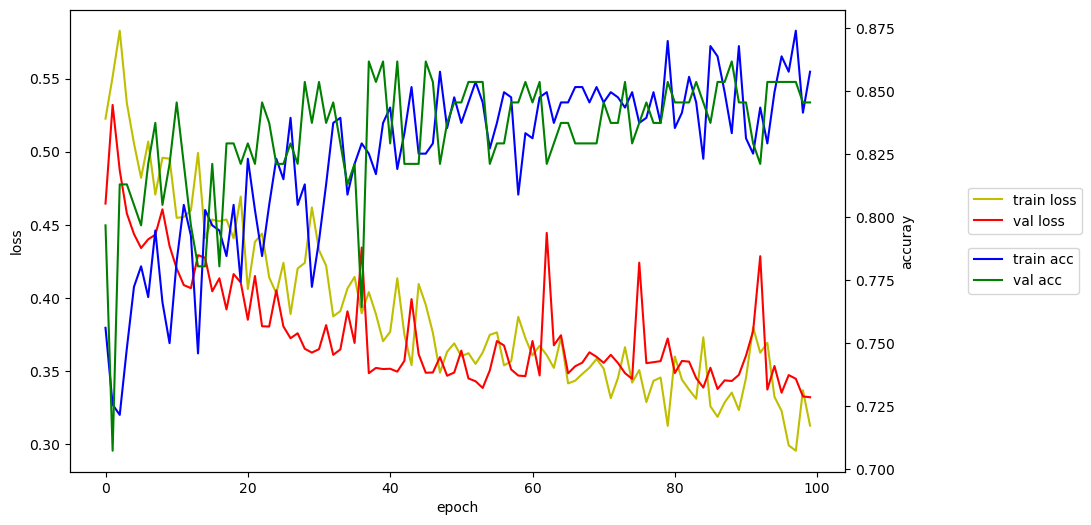

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10,6))
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left', bbox_to_anchor=(1.15, 0.5))
loss_ax.legend(loc='lower left', bbox_to_anchor=(1.15, 0.5))

plt.show()

# COVID-19 face mask detector in real-time video streams with OpenCV

In [68]:
import cv2
import numpy as np
from keras.models import load_model

labels_dict={1:'with_mask', 0:'without_mask'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [69]:
#video stream source : webcam or recorded video 

source=cv2.VideoCapture(0)
# cap = cv2.VideoCapture('test_mask.mp4')

In [70]:
# video output

fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
out = cv2.VideoWriter('output.avi', fourcc, 20, (640,480))

In [71]:
# warning sound in case of without_mask

import pygame, sys
from pygame import mixer

pygame.init()
pygame.mixer.init()

sound = mixer.Sound('alarm.wav')

In [72]:
# face recognition/classifier : haar feature
face_clsfr=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# face mask detector
model = load_model('100-0.3322.model')

while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for x,y,w,h in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        
        if(labels_dict[label] == 'with_mask'):
            print("No Beep")
        else:
            sound.play()
            print("Beep")   
        
        cv2.putText(
          img, "{}: {:.2f}%".format(labels_dict[label], np.max(result) * 100),            
          (x, y-10),
          cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    out.write(img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

source.release()
out.release()

cv2.destroyAllWindows()

1/1 [==============================] - 0s 78ms/step
No Beep
1/1 [==============================] - 0s 47ms/step
Beep
1/1 [==============================] - 0s 39ms/step
Beep
1/1 [==============================] - 0s 43ms/step
Beep
1/1 [==============================] - 0s 37ms/step
Beep
1/1 [==============================] - 0s 48ms/step
Beep
1/1 [==============================] - 0s 41ms/step
Beep
1/1 [==============================] - 0s 40ms/step
Beep
1/1 [==============================] - 0s 42ms/step
Beep
1/1 [==============================] - 0s 36ms/step
Beep
1/1 [==============================] - 0s 34ms/step
Beep
1/1 [==============================] - 0s 38ms/step
Beep
1/1 [==============================] - 0s 35ms/step
Beep
1/1 [==============================] - 0s 34ms/step
Beep
1/1 [==============================] - 0s 45ms/step
Beep
1/1 [==============================] - 0s 51ms/step
Beep
1/1 [==============================] - 0s 37ms/step
Beep
1/1 [=======================

1/1 [==============================] - 0s 33ms/step
Beep
1/1 [==============================] - 0s 31ms/step
Beep
1/1 [==============================] - 0s 36ms/step
Beep
1/1 [==============================] - 0s 33ms/step
Beep
1/1 [==============================] - 0s 33ms/step
Beep
1/1 [==============================] - 0s 31ms/step
Beep
1/1 [==============================] - 0s 32ms/step
Beep
1/1 [==============================] - 0s 35ms/step
Beep
1/1 [==============================] - 0s 30ms/step
Beep
1/1 [==============================] - 0s 37ms/step
Beep
1/1 [==============================] - 0s 35ms/step
Beep
1/1 [==============================] - 0s 33ms/step
Beep
1/1 [==============================] - 0s 35ms/step
Beep
1/1 [==============================] - 0s 33ms/step
Beep
1/1 [==============================] - 0s 32ms/step
Beep
1/1 [==============================] - 0s 33ms/step
Beep
1/1 [==============================] - 0s 50ms/step
Beep
1/1 [==========================

1/1 [==============================] - 0s 29ms/step
Beep
1/1 [==============================] - 0s 31ms/step
Beep
1/1 [==============================] - 0s 35ms/step
Beep
1/1 [==============================] - 0s 28ms/step
Beep
1/1 [==============================] - 0s 33ms/step
Beep
1/1 [==============================] - 0s 29ms/step
Beep
1/1 [==============================] - 0s 27ms/step
Beep
1/1 [==============================] - 0s 36ms/step
Beep
1/1 [==============================] - 0s 34ms/step
Beep
1/1 [==============================] - 0s 30ms/step
Beep
1/1 [==============================] - 0s 33ms/step
Beep
1/1 [==============================] - 0s 31ms/step
Beep
1/1 [==============================] - 0s 30ms/step
Beep
1/1 [==============================] - 0s 30ms/step
Beep
1/1 [==============================] - 0s 32ms/step
Beep
1/1 [==============================] - 0s 29ms/step
Beep
1/1 [==============================] - 0s 31ms/step
Beep
1/1 [==========================

#### Example : capturing a video

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('capture_result.png')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [50]:
import cv2

# Haar cascade 분류기 로드
face_clsfr = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 비디오 캡처 열기
source = cv2.VideoCapture(0)

while True:
    ret, img = source.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 얼굴 감지
    faces = face_clsfr.detectMultiScale(gray, 1.3, 5)
    
    for x, y, w, h in faces:
        # 얼굴 영역에 사각형 그리기
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
    # 화면에 이미지 표시
    cv2.imshow('Face Detection', img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

source.release()
cv2.destroyAllWindows()
